In [3]:
import pandas as pd
import numpy as np
import random
from sklearn import datasets
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Image
from IPython.core.display import HTML 
import warnings
warnings.filterwarnings('ignore')


In [4]:
# Read in dataset
data = datasets.load_boston()
df = pd.DataFrame(data['data']).set_axis(data['feature_names'], axis=1)
df['target'] = data['target']

In [5]:
df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,target
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


In [6]:
# Transform tabular data into vectors and matrixes 
X = df.iloc[:,:-1].values
y = df.target.values

### Train test split

In [7]:
def train_test_split(X, y, test_size):
    # Index the array
    indices = list(range(len(X)))
    
    # Find the train size, round() to avoid decimal values
    train_size = round((1-test_size)*len(X))
    
    # Randomly shuffle the indices
    random.shuffle(indices)
    
    # Split the training & testing samples
    X_train= X[indices[:train_size]]
    y_train = y[indices[:train_size]]
    X_test = X[indices[train_size:]]
    y_test = y[indices[train_size:]]
    
    return X_train, y_train, X_test, y_test

In [8]:
test_size = 0.2
X_train, y_train, X_test, y_test = train_test_split(X, y, test_size)

## Building the algorithm
There are 2 approaches to finding the optimal coefficients (theta) in Linear Regression:
1. Normal equation - works well with **small** number of features
2. Gradient descent - works well with **large** number of features

### 1. Normal Equation
The optimal beta or coefficients, i.e. the weights for different X's, can be found by the following formula, i.e. normal equation.

In [266]:
Image(url= "https://miro.medium.com/max/650/0*-tTqZlpNZdwb4BKz")

In [9]:
# Fit training samples to the above equation to find the optimal weights
def normal_equation(X, y):
    coef = np.dot((np.linalg.inv(np.dot(X.T,X))), np.dot(X.T,y))
    return coef

# Predict y_hat based on the weights
def predict(X_test, coef):
    return np.dot(X_test, coef)

In [10]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Compute the score in terms of common metrics for regression tasks, namely MAE, RMSE, R-Square
def metrics(y_pred, y_test):
    
    # Mean Absolute Error
    MAE = np.mean(np.abs(y_pred-y_test))

    # Mean Squared Error (MSE) & RMSE 
    MSE = np.square(np.subtract(y_test,y_pred)).mean() 
    RMSE = np.sqrt(MSE)

    # R-Square
    rss = np.sum(np.square((y_test- y_pred)))
    mean = np.mean(y_test)
    sst = np.sum(np.square(y_test-mean))
    r_square = 1 - (rss/sst)

    return MAE, RMSE, r_square

In [11]:
coef = normal_equation(X_train, y_train)

# Coefficients and bias
print(f'Coefficients: {coef}')

Coefficients: [-0.09570701  0.05435168 -0.01151869  3.19817187 -0.45151776  5.81365237
 -0.01015115 -0.97952169  0.14870465 -0.00831867 -0.37027151  0.01229275
 -0.42546409]


In [12]:
# Predict with the optimal coefficients & bias
y_pred = np.dot(X_test, coef)

# Evaluate predictions
mae, rmse, r_sq = metrics(y_pred, y_test)
print(f'MAE: {mae:.4f}')
print(f'RMSE: {rmse:.4f}')
print(f'R-Square: {r_sq:.4f}')

MAE: 3.7509
RMSE: 5.6980
R-Square: 0.6797


### 1.1 Compare with Sklearn's Linear Regression

In [13]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# Evaluate predictions
mae, rmse, r_sq = metrics(y_pred, y_test)
print(f'MAE: {mae:.4f}')
print(f'RMSE: {rmse:.4f}')
print(f'R-Square: {r_sq:.4f}')

MAE: 3.8421
RMSE: 5.6146
R-Square: 0.6891


### 2. Gradient Descent
In the SGD approach, parameters (weights & baises) will be trained & optimized using gradient descent where we'll calculate the partial derivative of the loss function with respect to the weights (coefficients) and bias and then update the weights & biases gradually.

Normalizing input would allow gradient descent to converge faster.

In [14]:
# Feature scaling
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)


In [15]:
# Cost function
def cost(y , y_pred, kind='rmse'):
    if kind == 'rmse':
        return np.sqrt(np.sum((y - y_pred)**2)/len(y))
    elif kind == 'mse':
        return np.sum((y - y_pred)**2)/len(y)
    elif kind not in ['rmse', 'mse']:
        raise ValueError('Cost function not found.')

# Gradient descent to find optimal coefficients & bias
def gradient_descent(x, y, lr=0.0001, epochs=1000, cost_function='rmse'):
    coef = np.random.rand(x.shape[1])
    b = 0
    n = len(x)
    cost_history = []
    for i in range(epochs):
        y_pred = np.dot(x, coef) + b
        error = y - y_pred
        cost_ = cost(y, y_pred, kind=cost_function)
        cost_history.append(cost_)
        dw = (-2/n) * np.dot(x.T, error)
        db = (-2/n) * np.sum(error)
        coef -= lr * dw
        b -= lr * db
    return coef, b, cost_history


In [16]:
coef, b, cost_history = gradient_descent(X_train, y_train, lr=0.001, epochs=2000, cost_function='rmse')

In [17]:
# Coefficients and bias
print(f'Coefficients: {coef}')
print(f'Bias: {b}')

Coefficients: [-0.75046885  0.61675846 -0.42960907  0.80877266 -0.64371588  3.21374726
 -0.2242212  -1.81522455  0.76385033 -0.40366496 -1.9111776   0.76371449
 -3.10004536]
Bias: 21.925191942169782


<AxesSubplot:>

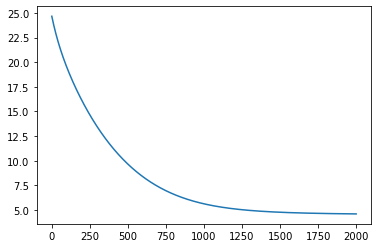

In [22]:
# Plot training history
sns.lineplot(data=cost_history)

In [19]:
# Predict with the optimal coefficients & bias
y_pred = np.dot(X_test, coef) + b

# Evaluate predictions
mae, rmse, r_sq = metrics(y_pred, y_test)
print(f'MAE: {mae:.4f}')
print(f'RMSE: {rmse:.4f}')
print(f'R-Square: {r_sq:.4f}')

MAE: 3.7265
RMSE: 5.8584
R-Square: 0.6615


### 2.1 Compare with Sklearn's SGDRegressor

In [20]:
from sklearn.linear_model import SGDRegressor

model = SGDRegressor(alpha=0.001, max_iter=2000)
model.fit(X_train, y_train)

SGDRegressor(alpha=0.001, max_iter=2000)

In [21]:
# Predict with trained coefficients & bias
y_pred = model.predict(X_test)

# Evaluate predictions
mae, rmse, r_sq = metrics(y_pred, y_test)
print(f'MAE: {mae:.4f}')
print(f'RMSE: {rmse:.4f}')
print(f'R-Square: {r_sq:.4f}')

MAE: 3.7859
RMSE: 5.7073
R-Square: 0.6787
